# Instability of Parameter Estimates

## Parameters

A *parameter* is anything that a model uses to constrain its predictions. Commonly, a parameter is a quantity that helps to describe a dataset of a distribution. For example, the mean of a normal distribution is a parameter; in fact, we say that a normal distribution is *parameterized* by its mean and variance. If we take the mean of a set of samples drawn from a normal distrubtion, we get an estimate of the mean of the distribution. Similarly, the mean of a set of observations is an estimate of the parameter of the underlying distribution (which is often assumed to be normal). Other parameters include the median, the correlation coefficient to another series, the standard deviation, and every other measurement of a dataset. 

### You Never Know. You Only Estimate

We you take the mean of a dataset, you do not know the mean. You have estimated the mean as best you can from the data you have. The esimate can be off. This is true for any parameter you estimate. To actually understand what is going on, you need to determine how good your estimate is by looking at its stability/standard error/confidence intervals.

## Instability of Estimates

When we consider a set of observations, our calculation of a parameter can only be an estimate. It will change as we take more measurements or as time passes and we get new observations. We can quantify the *uncertainty* in our estimate by looking at how the parameter changes as we look at different subsets of the data. For instance, standard deviation describes how different the mean of a set is from the mean of each observation; that is, from each observation itself. In financial applications, data often comes in time series. In this case, we can estimate a parameter at different points in time, say, for the previous 30 days. By looking at how much this moving estimate fluctuates as we change our time window, we can compute the instability of the estimated parameter.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Example: Mean and Standard Deviation

First, let's take a look at some samples from a normal distribution. We know that the mean of the distribution is 0 and the standard deviation is 1. But if we measure the parameters from our observations, we will get only approximately 0 and approximately 1. We can see how these estimates changes as we take more and more samples

0.44806111169875623
-0.10384651739409384
-0.0024229041215306567
0.006837994588647575


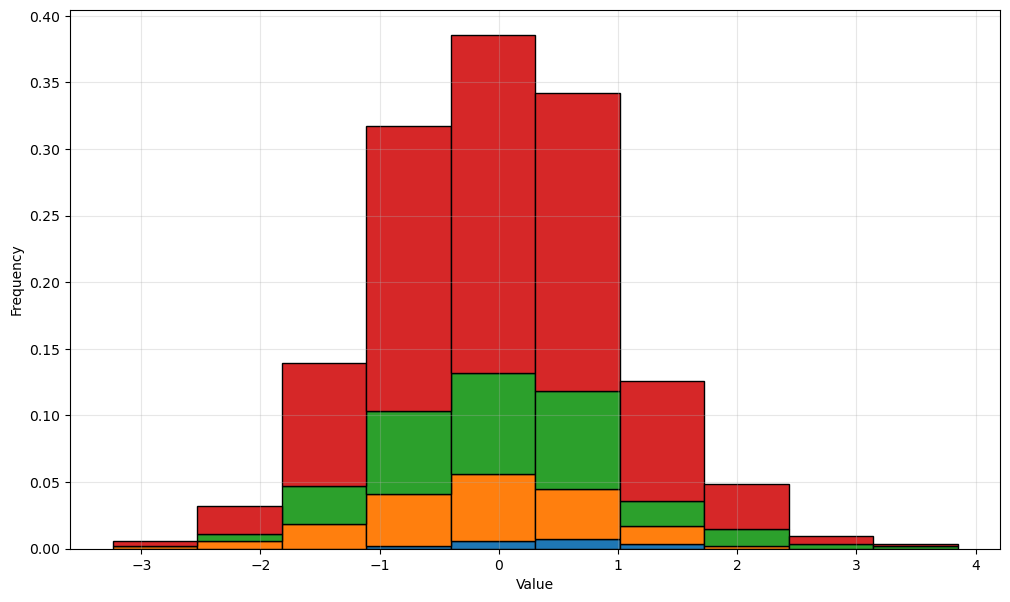

In [10]:
# Set a seed for randomness
np.random.seed(42)

# Random samples
normal = np.random.randn(500)
print(np.mean(normal[:10]))
print(np.mean(normal[:100]))
print(np.mean(normal[:250]))
print(np.mean(normal))

# Plot a stacked histogram of the data
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.hist([normal[:10], normal[10:100], normal[100:250], normal], density=True, histtype='bar', stacked=True, edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency");

In [8]:
print(np.std(normal[:10]))
print(np.std(normal[:100]))
print(np.std(normal[:250]))
print(np.std(normal))

0.6859059302944951
0.9036161766446296
0.9641196524603245
0.9802715029966268


Notice that, although the probability of getting closer to 0 for the mean and to 1 for the standard deviation increases with the number of samples, we don't always get better estimates by taking more data points. Whatever our expectation is, we can always get a different result, and our goal is often to compute the probability that the result is significantly different than expected.


### Example: Non-Normal Underlying Distribution

What happens if the underlying data is not normal? A mean will be very deceptive. Because of this, it's important to test for normality of our data. We'll use a Jarque-Bera test as an example.

In [15]:
# Generate some data from a bimodal distribution
def bimodal(n):
    X = np.zeros(n)
    for i in range(n):
        if np.random.binomial(1, 0.5) == 0:
            X[i] = np.random.normal(-5, 1)
        else:
            X[i] = np.random.normal(5, 1)
    return X

Mean: -0.24938061691558377
Standard Deviation: 5.11161748911235


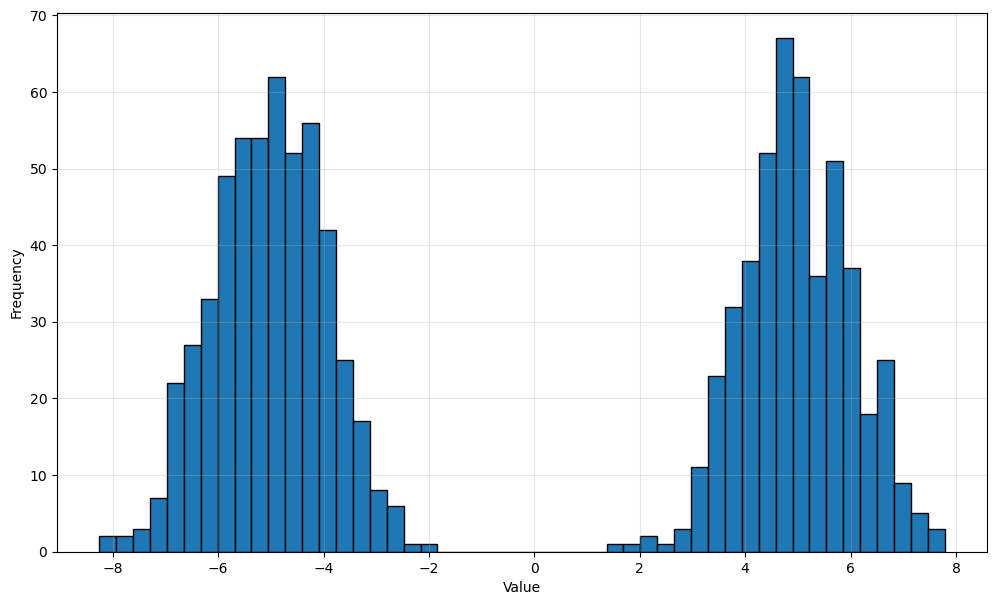

In [17]:
# Let's see how it looks
X = bimodal(1000)

plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.hist(X, bins=50, edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency")

print(f"Mean: {np.mean(X)}")
print(f"Standard Deviation: {np.std(X)}")

Sure enough, the mean is increadily non-informative about what is going on in the data. We have collapsed all of our data into a single estimate, and lost a lot of information doing so. This is what the distribution should look like if our hypothesis that it is normally distributed is correct.

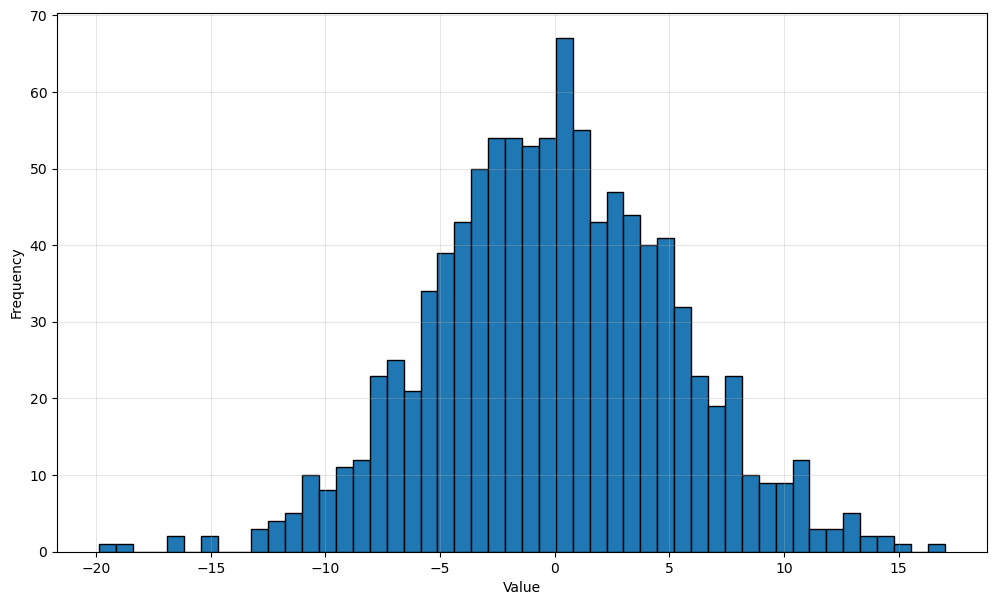

In [18]:
# Create a normal distribution with the given parameters
mu = np.mean(X)
sigma = np.std(X)

N = np.random.normal(mu, sigma, 1000)

plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.hist(N, bins=50, edgecolor="black")
plt.xlabel("Value")
plt.ylabel("Frequency");

We'll test our data using the Jarque-Bera test to see if it's normal. A significant p-value indicates non-normality.

In [ ]:
from statsmodels.stats.stattools import jarque_bera

jarque_bera(X) # (statistic, pvalue, skewness, kurtosis)

(140.49357088850098,
 3.106051913616017e-31,
 0.08350446684066992,
 1.1713519427198011)

Here, the p-value is 3.106051913616017e-31 < 0.05. Thus, we can conclude that X is not normal. This saves us from accidentially making horrible predictions.

### Example: Sharpe Ratio

One statistics often used to describe the performance of assets and portfolios is *Sharpe ratio*, which measures the additional return per unit additional risk achieved by a portfolio, relative to a risk-free source of return such as Treasury bills:

$$R = \frac{E[r_a - r_b]}{\sqrt{Var(r_a - r_b)}}$$

where $r_a$ is the returns on our asset and $r_b$ is the risk-free rate of return. As with mean and standard deviation, we can compute a rolling Sharpe ratio to see how estimate changes through time.

In [20]:
def sharpe_ratio(asset, riskfree):
    return np.mean(asset - riskfree) / np.std(asset - riskfree)

In [21]:
# Mock implementation of get_pricing function
import pandas as pd
import yfinance as yf

_FIELD_MAP = {
    "price": "Close",        # Quantopian "price" ~= daily close
    "open_price": "Open",
    "high": "High",
    "low": "Low",
    "close_price": "Close",
    "volume": "Volume",
    "adj_close": "Adj Close",
}

def get_pricing(symbol, start_date, end_date, fields="price", adjusted=False):
    if isinstance(symbol, str):
        tickers = [symbol]
    else:
        tickers = list(symbol)

    col = _FIELD_MAP.get(fields, fields)

    df = yf.download(
        tickers=tickers,
        start=start_date,
        end=end_date,
        interval="1d",
        auto_adjust=adjusted,
        actions=False,
        progress=False,
        group_by="ticker",
    )

    # Case 1: MultiIndex columns: (ticker, field)
    if isinstance(df.columns, pd.MultiIndex):
        # return Series for single ticker, DataFrame for multi tickers
        if len(tickers) == 1:
            t = tickers[0]
            if (t, col) not in df.columns:
                raise KeyError(f"Missing {(t, col)}. Available: {list(df.columns)}")
            out = df[(t, col)].copy()
            out.name = t
            return out
        else:
            out = {}
            for t in tickers:
                if (t, col) not in df.columns:
                    raise KeyError(f"Missing {(t, col)}. Available: {list(df.columns)[:10]} ...")
                out[t] = df[(t, col)]
            return pd.DataFrame(out)

    # Case 2: Flat columns: "Open", "High", ...
    else:
        if col not in df.columns:
            raise KeyError(f"Field '{fields}' mapped to '{col}' not found. Available: {list(df.columns)}")
        if len(tickers) == 1:
            out = df[col].copy()
            out.name = tickers[0]
            return out
        else:
            # In flat-column case with multiple tickers, yfinance usually returns MultiIndex,
            # but handle defensively anyway.
            return df[col].copy()

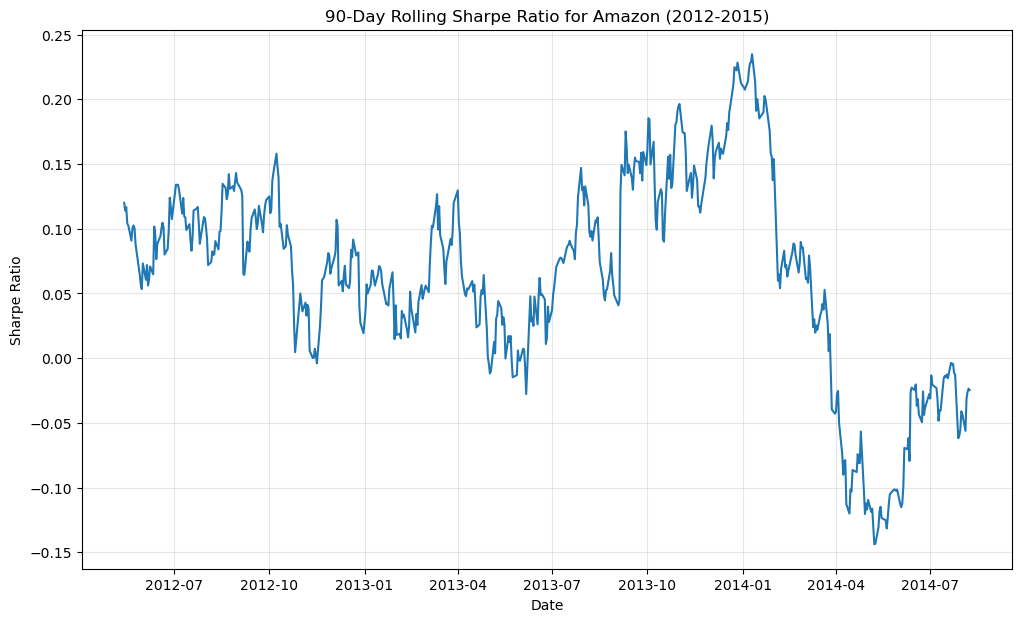

In [44]:
# Get the data
start = "2012-01-01"
end   = "2015-01-01"

# Use an ETF that tracks 3-month T-bills as our risk-free rate of return
treasury_ret = get_pricing("BIL", fields="price", start_date=start, end_date=end).pct_change()[1:]
pricing      = get_pricing("AMZN", fields="price", start_date=start, end_date=end)
returns      = pricing.pct_change()[1:]  # Get the returns on the asset

# Compute the running Sharpe ratio
running_sharpe = [sharpe_ratio(returns[i-90:i], treasury_ret[i-90:i]) for i in range(90, len(returns))]
dates = returns.index[90:]

# Plot running Sharpe ratio up to 100 days before the end of the dataset
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(dates[:-100], running_sharpe[:-100])
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title("90-Day Rolling Sharpe Ratio for Amazon (2012-2015)");

The Sharpe ratio looks rather volatile, and it's clear that just reporting it as a single value will not be very helpful for predicting future values. Instead, we can compute the mean and standard deviation of the data above, and then see if it helps us predict the Sharpe ratio for the next 100 days.

Mean of running Sharpe ratio: 0.06406518151615088
Standard deviation of running Sharpe ratio: 0.077749234173722


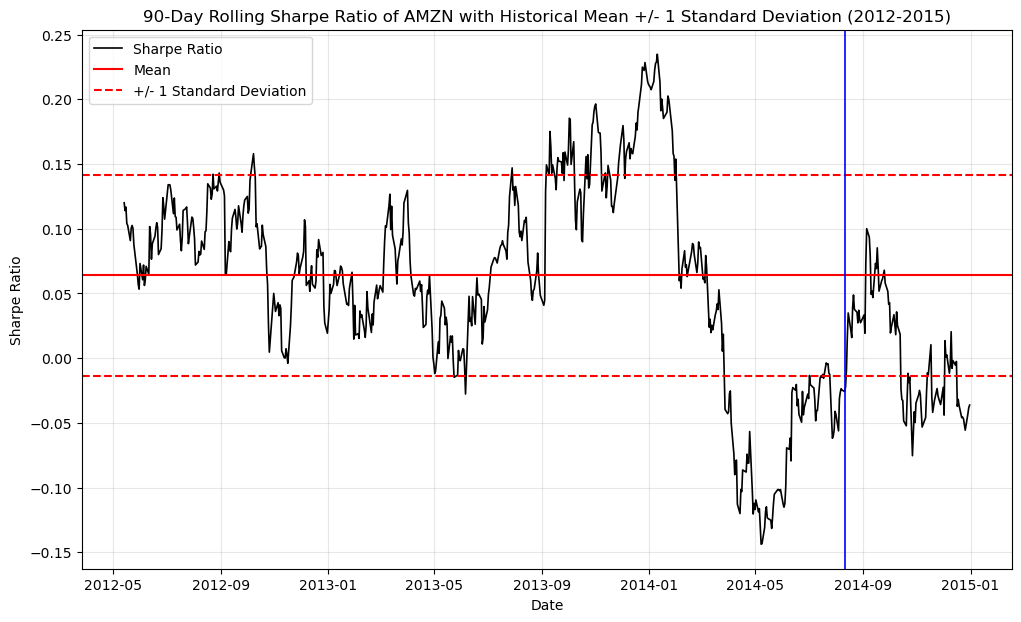

In [58]:
# Compute the mean and standard deviation of the running Sharpe ratios up to 100 days before the end
means_rs = np.mean(running_sharpe[:-100])
std_rs   = np.std(running_sharpe[:-100])

# Plot the running Sharpe ratio
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(dates, running_sharpe, color="black", lw=1.2)

# Plot its mean and the +/- 1 standard deviation lines
plt.axhline(means_rs, color="red")
plt.axhline(means_rs + std_rs, linestyle="--", color="red")
plt.axhline(means_rs - std_rs, linestyle="--", color="red")

# Indicate up to where we computed the mean and standard deviations
plt.axvline(dates[-100], color="blue", lw=1.2)

# Add labels
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.legend(["Sharpe Ratio", "Mean", "+/- 1 Standard Deviation"])
plt.title("90-Day Rolling Sharpe Ratio of AMZN with Historical Mean +/- 1 Standard Deviation (2012-2015)");

# Print some statistics
print(f"Mean of running Sharpe ratio: {means_rs}")
print(f"Standard deviation of running Sharpe ratio: {std_rs}")

The standard deviation in this case is about a quarter of the range, so this data is extremely volatile. Taking this into account when looking ahead gave a better prediction than just using the mean, although we still observed data more than one standard deviation away. We could also compute the rolling mean of the Sharpe ratio and try to follow the trends. But in that case, too, we should keep in mind the standard deviation.

### Example: Moving Average

Let's say we take the average with a lookback window. How would we determine the standard error on that estimate? Let's start with an example showing a 90-day moving average.

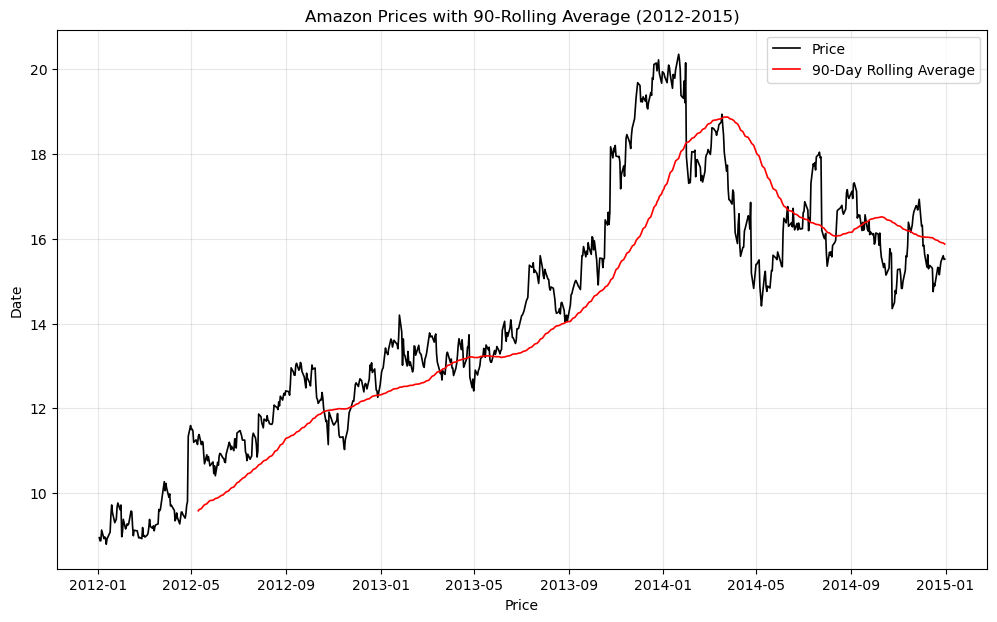

In [68]:
# Load time-series data of prices
start = "2012-01-01"
end   = "2015-01-01"
pricing = get_pricing("AMZN", fields="price", start_date=start, end_date=end, adjusted=True)

# Compute the 90-day rolling mean for each day
mu = pricing.rolling(window=90).mean()

# Plot the pricing data with rolling mean
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(pricing, label="Price", color="black", lw=1.2)
plt.plot(mu, label="90-Day Rolling Average", color="red", lw=1.2)
plt.xlabel("Price")
plt.ylabel("Date")
plt.legend()
plt.title("Amazon Prices with 90-Rolling Average (2012-2015)");

This lets us see the instability/standard error of the mean, and helps anticipate future variability in the data. We can quantify this variabiltiy by compute the mean and standard deviation of the rolling mean.

In [69]:
print(f"Mean of the rolling mean: {np.mean(mu)}")
print(f"Standard deviation of the rolling mean: {np.std(mu)}")

Mean of the rolling mean: 14.419316972447318
Standard deviation of the rolling mean: 2.556757507580367


In fact, the standard deviation, for which we use to quantify variability, is itself variable. Below we plot the rolling standard deviation (for a 90-day window), and compute its mean and standard deviation.

Mean of rolling std: 0.8701913782700503
Standard deviation of rolling std: 0.3772346255500085


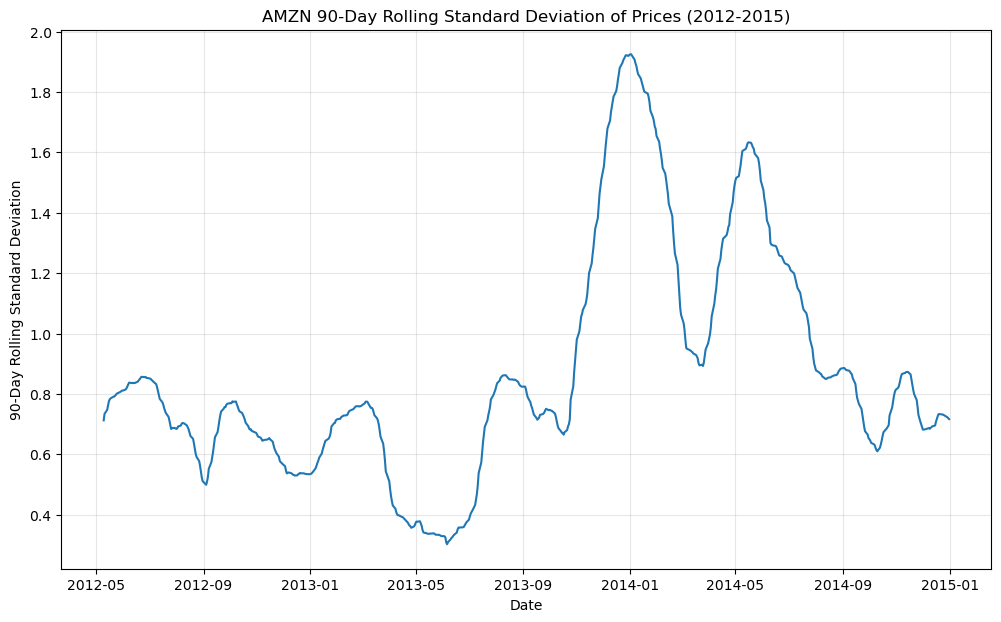

In [73]:
# Compute rolling standard deviation
std = pricing.rolling(window=90).std()

# Plot the rolling standard deviation
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(std)
plt.xlabel("Date")
plt.ylabel("90-Day Rolling Standard Deviation")
plt.title("AMZN 90-Day Rolling Standard Deviation of Prices (2012-2015)");

# Print some statistics
print(f"Mean of rolling std: {np.mean(std)}")
print(f"Standard deviation of rolling std: {np.std(std)}")

To see what this changing standard deviation means for our dataset, let's plot the data again along with the *Bollinger bands*: the rolling mean, one rolling standard deviation (of the data) above the mean, and one standard deviation below.

Note that although standard deviations give us more information about the spread of the data, we cannot assign precise probabilities to our expectations for future observations without assuming a particular distribution for the underlying process.

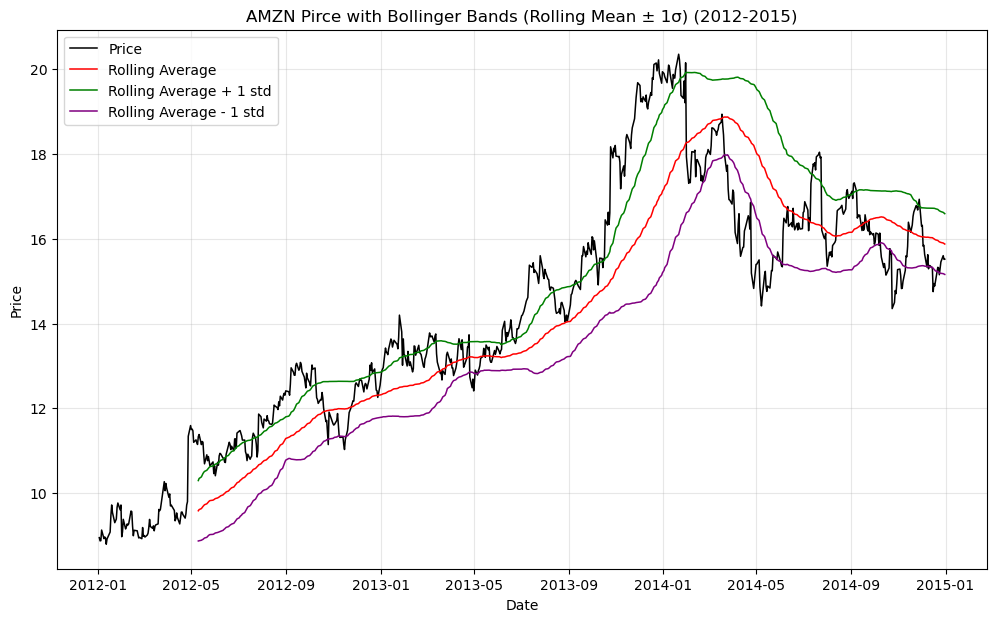

In [81]:
# Plot the original data
plt.figure(figsize=(12, 7))
plt.grid(alpha=0.3)
plt.plot(pricing, label="Price", color="black", lw=1.1)

# Plot the Bollinger band
plt.plot(mu, label="Rolling Average", color="red", lw=1.1)
plt.plot(mu + std, label="Rolling Average + 1 std", color="green", lw=1.1)
plt.plot(mu - std, label="Rolling Average - 1 std", color="purple", lw=1.1)

# Labeling
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("AMZN Pirce with Bollinger Bands (Rolling Mean ± 1σ) (2012-2015)");

## Conclusion

Whenever we compute a parameter for a dataset, we should also compute its volatility. Otherwise, we do not know whether or not we should expect new data points to be aligned with this parameter. A good way of computing volatility is dividing the data into subsets and estimating the parameter from each one, then finding the variability among the results. There may still be outside factors which are introduced after our sample period and which we cannot predict. However, the instability analysis and testing for standard error is still very useful for telling us how much we should trust/distrust our estimates.